In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapezoid
from scipy.interpolate import RectBivariateSpline  # type: ignore


# particula imports
from particula.next.dynamics.coagulation import brownian_kernel, rate
from particula.next.particles.properties.lognormal_size_distribution import (
    lognormal_pmf_distribution, lognormal_pdf_distribution
)
from particula.util.convert import distribution_convert_pdf_pms

## Create both a PDF and PMF


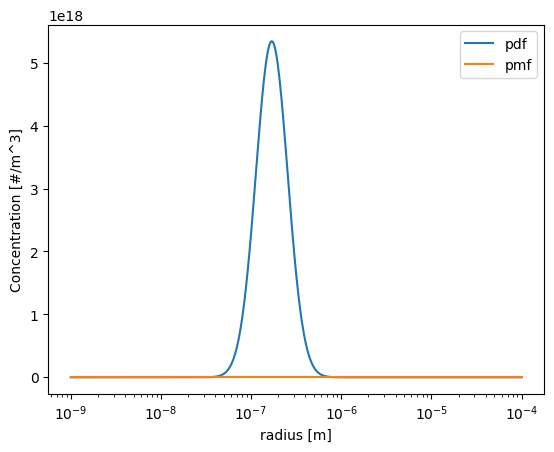

In [86]:
# Distribution parameters
mode = np.array([200e-9])
std = np.array([1.5])
number = np.array([1e6]) * 1e6 # 1e6 particles per cm^3 converted to m^3
radius_bins = np.logspace(start=-9, stop=-4, num=500)

# create the distribution
distribution_pdf = lognormal_pdf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=std,
    number_of_particles=number
)
distribution_pmf = lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=std,
    number_of_particles=number
)

# Plot the distribution
plt.figure()
plt.plot(radius_bins, distribution_pdf, label='pdf')
plt.plot(radius_bins, distribution_pmf, label='pmf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

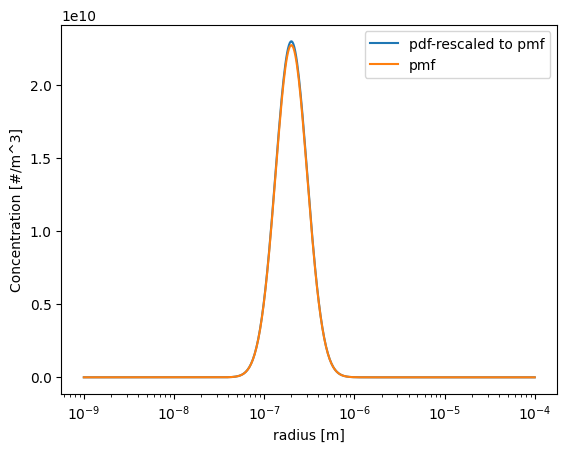

In [87]:
# rescale PDF to PMF
distribution_pdf_rescaled = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=distribution_pdf,
    to_pdf=False
)

# # Plot the distribution
plt.figure()
plt.plot(radius_bins, distribution_pdf_rescaled, label='pdf-rescaled to pmf')
plt.plot(radius_bins, distribution_pmf, label='pmf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()


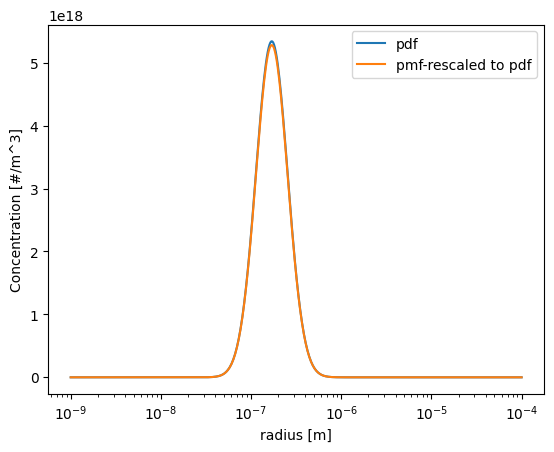

In [88]:
# pmf scaled to pdf
distribution_pmf_rescaled = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=distribution_pmf,
    to_pdf=True
)

plt.figure()
plt.plot(radius_bins, distribution_pdf, label='pdf')
plt.plot(radius_bins, distribution_pmf_rescaled, label='pmf-rescaled to pdf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
plt.legend()
plt.show()

In [89]:
# Check number concentration PDF integration
number_concentration_pdf = trapezoid(distribution_pdf, x=radius_bins)
number_concentration_pmf_rescaled = trapezoid(distribution_pmf_rescaled, x=radius_bins)

print(f'Number concentration PDF: {number_concentration_pdf}')
print(f'Number concentration PMF rescaled to PDF: {number_concentration_pmf_rescaled}')

# Check number concentration PMF integration
number_concentration_pmf = distribution_pmf.sum()
number_concentration_pdf_rescaled = distribution_pdf_rescaled.sum()

print(f'Number concentration PMF: {number_concentration_pmf}')
print(f'Number concentration PDF rescaled to PMF: {number_concentration_pdf_rescaled}')

Number concentration PDF: 1000000000000.0
Number concentration PMF rescaled to PDF: 988596064185.8999
Number concentration PMF: 1000000000000.0
Number concentration PDF rescaled to PMF: 1011535485753.2141


In [91]:
# Get the kernel
mass_bins = 4 / 3 * np.pi * radius_bins**3 * 1e3  # kg

kernel = brownian_kernel.brownian_coagulation_kernel_via_system_state(
    radius_particle=radius_bins,
    mass_particle=mass_bins,
    temperature=293.15,
    pressure=101325,
    alpha_collision_efficiency=1
)

# Coagulation rate PDF
concentration_0 = distribution_pdf
gain_pdf = rate.continuous_gain(
    radius=radius_bins,
    concentration=concentration_0,
    kernel=kernel,
)
loss_pdf = rate.continuous_loss(
    radius=radius_bins,
    concentration=concentration_0,
    kernel=kernel
)
net_pdf = gain_pdf - loss_pdf

# convert to volume distribution
gain_volume = gain_pdf * 4 / 3 * np.pi * radius_bins**3
loss_volume = loss_pdf * 4 / 3 * np.pi * radius_bins**3
net_volume = net_pdf * 4 / 3 * np.pi * radius_bins**3

# integrate the gain, loss and net
gain_total_volume = trapezoid(gain_volume, x=radius_bins)
loss_total_volume = trapezoid(loss_volume, x=radius_bins)
net_total_volume = trapezoid(net_volume, x=radius_bins)

print(f'Gain total volume: {gain_total_volume}')
print(f'Loss total volume: {loss_total_volume}')
print(f'Net total volume: {net_total_volume}')

Gain total volume: 6.75165104833036e-11
Loss total volume: 6.752244952802652e-11
Net total volume: -5.9390447229141716e-15


In [90]:
# Coagulation rate PMF
concentration_0_pmf = distribution_pmf
gain_pmf = rate.discrete_gain(
    concentration=concentration_0_pmf,
    kernel=kernel,
)
loss_pmf = rate.discrete_loss(
    concentration=concentration_0_pmf,
    kernel=kernel
)
net_pmf = gain_pmf - loss_pmf

# convert to volume distribution
gain_volume_pmf = gain_pmf * 4 / 3 * np.pi * radius_bins**3
loss_volume_pmf = loss_pmf * 4 / 3 * np.pi * radius_bins**3
net_volume_pmf = net_pmf * 4 / 3 * np.pi * radius_bins**3

# sum the gain, loss and net
gain_total_volume_pmf = gain_volume_pmf.sum()
loss_total_volume_pmf = loss_volume_pmf.sum()
net_total_volume_pmf = net_volume_pmf.sum()

print(f'Gain total volume PMF: {gain_total_volume_pmf}')
print(f'Loss total volume PMF: {loss_total_volume_pmf}')
print(f'Net total volume PMF: {net_total_volume_pmf}')

Gain total volume PMF: 6.069056561568663e-11
Loss total volume PMF: 6.75224495280265e-11
Net total volume PMF: -6.8318839123398844e-12


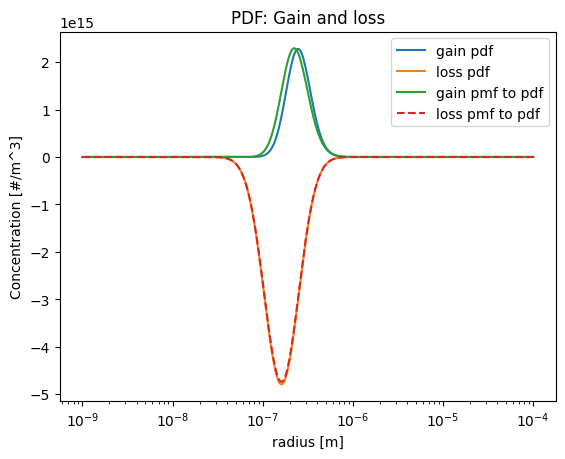

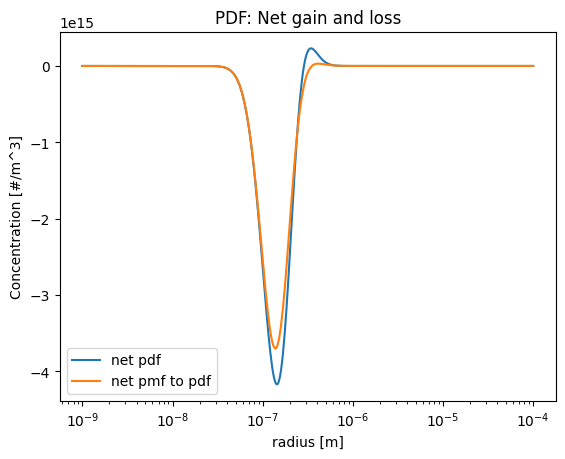

In [92]:
# Convert the PMF to PDF
gain_pmf_to_pdf = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=gain_pmf,
    to_pdf=True
)
loss_pmf_to_pdf = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=loss_pmf,
    to_pdf=True
)
net_pmf_to_pdf = gain_pmf_to_pdf - loss_pmf_to_pdf


# plot the results
plt.figure()
plt.plot(radius_bins, gain_pdf, label='gain pdf')
plt.plot(radius_bins, -1*loss_pdf, label='loss pdf')
# plt.plot(radius_bins, net_pdf, label='net pdf')
plt.plot(radius_bins, gain_pmf_to_pdf, label='gain pmf to pdf')
plt.plot(radius_bins, -1*loss_pmf_to_pdf, label='loss pmf to pdf', linestyle='--')
# plt.plot(radius_bins, net_pmf_to_pdf, label='net pmf to pdf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
# plt.yscale('log')
plt.title('PDF: Gain and loss')
plt.legend()
plt.show()

# Net gain and loss
plt.figure()
plt.plot(radius_bins, net_pdf, label='net pdf')
plt.plot(radius_bins, net_pmf_to_pdf, label='net pmf to pdf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
plt.title('PDF: Net gain and loss')
plt.legend()
plt.show()


In [104]:
# Time steps

# inital distribution
distribution_0 = distribution_pdf

distribution_i = distribution_0

time_array = np.linspace(start=0, stop=1000, num=50)
time_interval = time_array[1] - time_array[0]

distribution_time = np.zeros([len(time_array), len(distribution_0)])

for i, dpa in enumerate(time_array):

    if i > 0:
        # calculate coagulations
        coag_gain_i = rate.continuous_gain(
            radius=radius_bins,
            concentration=distribution_i,
            kernel=kernel,
        )
        coag_loss_i = rate.continuous_loss(
            radius=radius_bins,
            concentration=distribution_i,
            kernel=kernel
        )

        net_change = (coag_gain_i - coag_loss_i) * time_interval
        distribution_i = distribution_i + net_change
        # if less than zero, set to zero
        distribution_i[distribution_i < 0] = 0

    distribution_time[i, :] = distribution_i

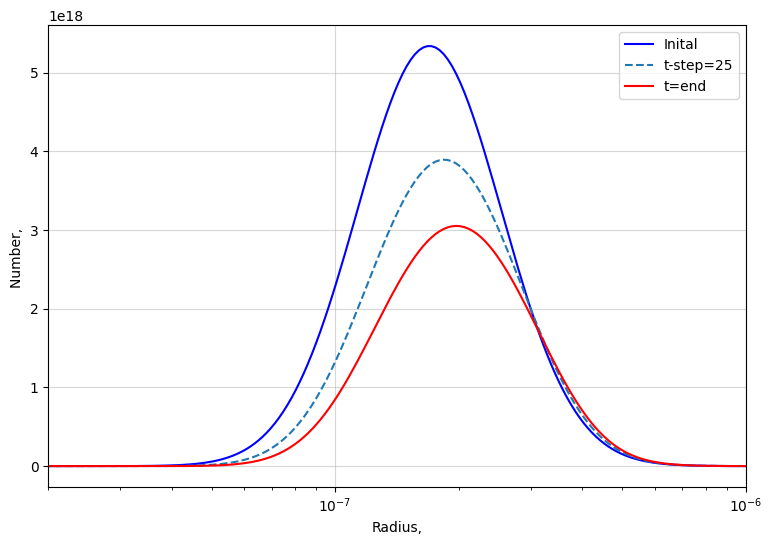

In [105]:
fig, ax = plt.subplots(1, 1, figsize=[9, 6])

radius = radius_bins
ax.semilogx(radius, distribution_0, "-b", label="Inital")
ax.semilogx(radius, distribution_time[25, :], "--", label="t-step=25")
ax.semilogx(radius, distribution_time[-1, :], "-r", label="t=end")
ax.set_xlim([2e-8, 1e-6])
ax.legend()
ax.set_ylabel(f"Number")
ax.set_xlabel(f"Radius,")
ax.grid(True, alpha=0.5)